# A Data Adventure in Dimensionality Reduction using PCA

We are given a high-dimensional, fully categorical dataset about mushrooms. Each sample is labelled `edible(e)` or `poisonous(p)`. The dataset contains many categorical attributes which are redundant or correlated (for instance, cap-shape and cap-surface *could* be correlated). Our goals:

1. Preprocess the data so it's suitable for PCA (one-hot encoding, scaling) — explain why each step is needed.
2. Use PCA to reduce dimensionality and inspect how much variance each principal component explains (Scree plot).
3. Visualize the data in the principal component space to inspect class separability.
4. Train a baseline Logistic Regression on the full (standardized) feature set and another Logistic Regression on PCA-transformed features (using the number of components chosen from the scree/cumulative variance criteria) and compare performance.

Throughout, we tell the story: *Does PCA allow us to compress the dataset with little performance loss?* If yes, by how much? If no, why not?

---

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

sns.set(style='whitegrid')

## Part A: Exploratory Data Analysis (EDA) & Preprocessing

In [50]:
df = pd.read_csv('./mushrooms_dataset/mushrooms.csv')
print(f"Raw dataset shape: {df.shape}")
df.head()

Raw dataset shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


- All the features are categorical. PCA requires numerical input.
- **One-hot encoding** transforms categorical variables into numeric binary columns. This increases dimensionality ("the curse of dimensionality"), but preserves the nominal information.
- **Why one-hot (and not label-encoding)?** Label encoding would assign arbitrary numeric order to categories which PCA would treat as ordinal; one-hot avoids that.

In [32]:
X_raw = df.drop(columns=['class'])
# Convert target to binary numeric: edible=0, poisonous=1
y = df['class'].map({'e': 0, 'p': 1}).astype(int)

# One-hot encode all categorical features
X = pd.get_dummies(X_raw, prefix_sep='=')

print('\nAfter one-hot encoding:')
print(f'X shape: {X.shape}')
print(f'Number of features after encoding: {X.shape[1]}')

print('\nFirst 30 feature columns:')
print(X.columns[:30].tolist())


After one-hot encoding:
X shape: (8124, 117)
Number of features after encoding: 117

First 30 feature columns:
['cap-shape=b', 'cap-shape=c', 'cap-shape=f', 'cap-shape=k', 'cap-shape=s', 'cap-shape=x', 'cap-surface=f', 'cap-surface=g', 'cap-surface=s', 'cap-surface=y', 'cap-color=b', 'cap-color=c', 'cap-color=e', 'cap-color=g', 'cap-color=n', 'cap-color=p', 'cap-color=r', 'cap-color=u', 'cap-color=w', 'cap-color=y', 'bruises=f', 'bruises=t', 'odor=a', 'odor=c', 'odor=f', 'odor=l', 'odor=m', 'odor=n', 'odor=p', 'odor=s']


#### One-hot expanded the data from `N_features_original = 23` categorical features to `N_dummies = 117` binary columns. This is expected and creates a high-dimensional but sparse representation.
---
- After one-hot, many columns are sparse and possibly collinear (e.g., groups of dummies for the same original categorical feature sum to 1). This is why standardization is needed.
- Standardization: Even though features are binary, we standardize to give each feature zero mean and unit variance.
- Reason: PCA is sensitive to scale; features with larger variance dominate the principal components. Binary indicators
  can have different variances depending on category frequencies; scaling ensures fair treatment.
- Standardization is applied to avoid dominance of features with larger variance and to create an appropriate input for PCA.

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print('\nStandardization complete. Mean (approx) per-feature:')
print(np.round(X_scaled_df.mean().values[:5], 6), '...')
print('Std (approx) per-feature:')
print(np.round(X_scaled_df.std().values[:5], 6), '...')


Standardization complete. Mean (approx) per-feature:
[-0.  0.  0. -0. -0.] ...
Std (approx) per-feature:
[1.000062 1.000062 1.000062 1.000062 1.000062] ...


## Part B: Principal Component Analysis (PCA)
### Goals & reasoning
- Use PCA to inspect how much of the dataset variance is concentrated in a few directions, and reduce dimensionality for downstream modeling while controlling information loss.
- We'll first fit PCA on the entire standardized dataset to compute explained variance ratios and create the scree plot. When using PCA as a preprocessing step for supervised learning, PCA should be fit on the *training set only* to avoid data leakage. We'll do that later during modeling.

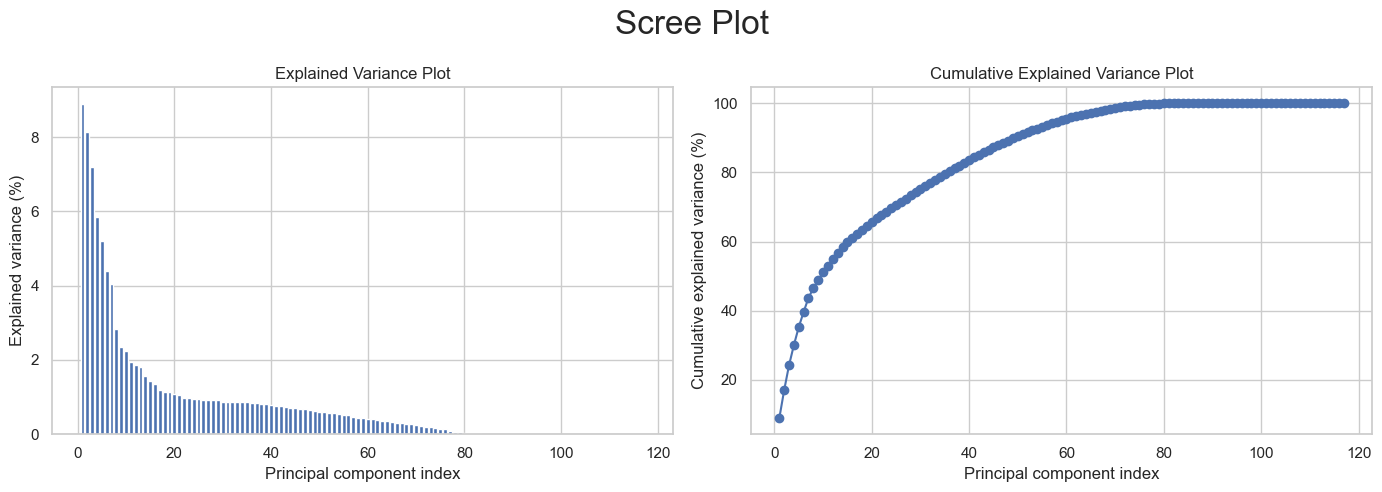

In [47]:
pca_full = PCA() 
pca_full.fit(X_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_ 
cumulative_variance = np.cumsum(explained_variance_ratio)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
# Explained variance ratio
axes[0].bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio * 100)
axes[0].set_xlabel('Principal component index')
axes[0].set_ylabel('Explained variance (%)')
axes[0].set_title('Explained Variance Plot')
# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance * 100, marker='o')
axes[1].set_xlabel('Principal component index')
axes[1].set_ylabel('Cumulative explained variance (%)')
axes[1].set_title('Cumulative Explained Variance Plot')

fig.suptitle('Scree Plot', fontsize=24)  
plt.tight_layout()
plt.show()

### Scree plot interpretation
- The Scree plot shows how variance is distributed across principal components. In many one-hot encoded categorical datasets, variance may be spread across many components because each dummy column can carry some unique variance.
- As you can see from the Scree plot, after around **'78'** principal components the explained variance is negligible
- The cumulative explained variance plot says that we retain almost 100% of the variance with just **'70'** principal components

In [35]:
cutoff = 0.90
n_comp = np.argmax(cumulative_variance >= cutoff) + 1
print(f'Number of components to retain {int(cutoff*100)}% variance: {n_comp}')

Number of components to retain 90% variance: 50


#### Let's set our target to retain around `90%` of the variance, this comes up to around First `50` Principal Components

------

### Visualize projection onto the first two principal components

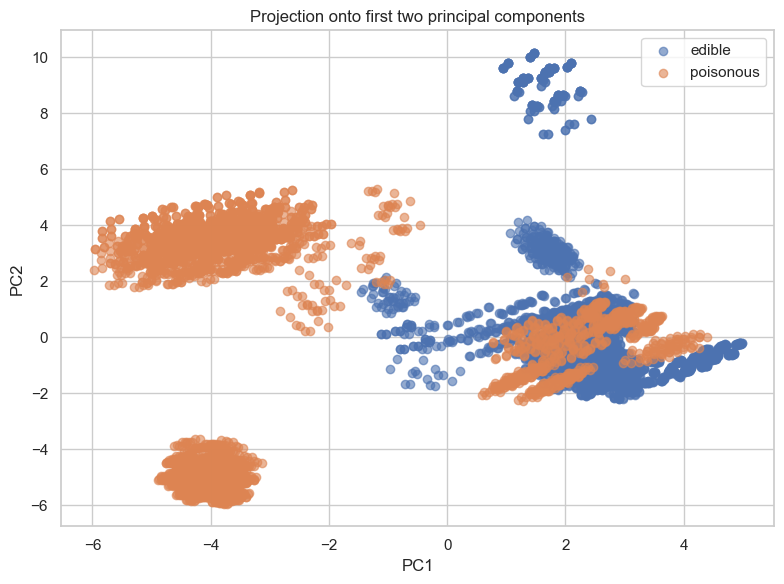

In [36]:
X_pca_full = pca_full.transform(X_scaled)
pc_df = pd.DataFrame({
    'PC1': X_pca_full[:,0],
    'PC2': X_pca_full[:,1],
    'class': y
})

plt.figure(figsize=(8,6))
palette = {0: 'C0', 1: 'C1'}
for cls, grp in pc_df.groupby('class'):
    plt.scatter(grp['PC1'], grp['PC2'], label=('edible' if cls==0 else 'poisonous'), alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection onto first two principal components')
plt.legend()
plt.tight_layout()
plt.show()

- Classes aren't well-separated in PC1-PC2 space, (i.e) there's no clear distinction of both classes in this space.
- Often, because PCA is unsupervised (it maximizes variance, not class separation), the classes may not be cleanly separated on the first two PCs.

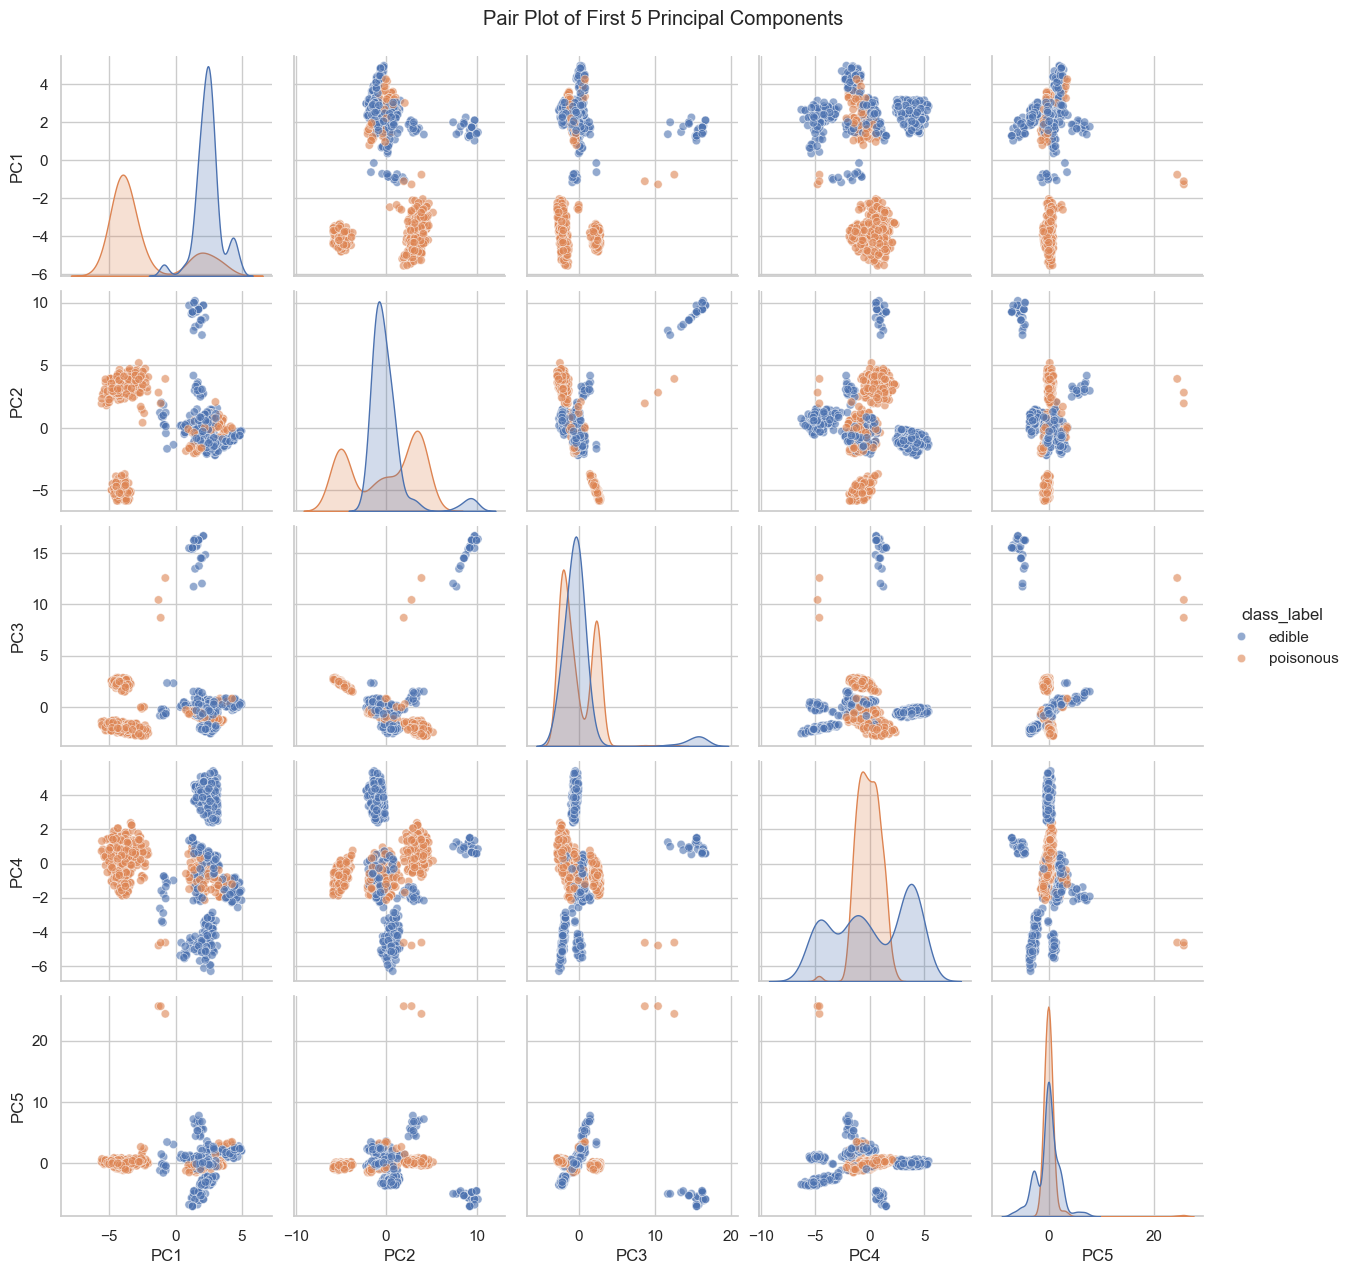

In [49]:
# Analyse the pair-wise plot of first 5 principal components
num_pcs_to_plot = 5
pc_scores = pca_full.transform(X_scaled)[:, :50]

pairplot_df = pd.DataFrame(pc_scores[:, :num_pcs_to_plot], columns=[f'PC{i+1}' for i in range(num_pcs_to_plot)])
pairplot_df['class'] = y.reset_index(drop=True)
pairplot_df['class_label'] = pairplot_df['class'].map({0: 'edible', 1: 'poisonous'})

plot_cols = [f'PC{i+1}' for i in range(num_pcs_to_plot)] + ['class_label']
plot_df = pairplot_df[plot_cols]
sample_df = plot_df.sample(n=1000, random_state=42)

sns.pairplot(sample_df, hue='class_label', diag_kind='kde', palette={'edible': 'C0', 'poisonous': 'C1'}, plot_kws={'alpha':0.6})
plt.suptitle(f'Pair Plot of First {num_pcs_to_plot} Principal Components', y=1.02)
plt.show()

### Interpretation (Pair Plots)
- Pair plots show how the classes (edible vs poisonous) distribute across combinations of PCs.
- If we see distinct clusters or reduced overlap, PCA has aligned axes of high variance in ways that aid class separation.
- In this dataset, overlap often remains: PCA maximizes variance, not class separation. Thus, while some PCs may help distinguish classes, PCA alone does not guarantee separability.
- Conclusion: **The reduced feature space is orthogonalized and compact (good for modeling), but complete class separation is not achieved with PCA alone.**

## Part C: Performance Evaluation (Logistic Regression)

We'll evaluate a **baseline Logistic Regression** trained on the **original standardized features** (no PCA) and compare it to a Logistic Regression trained on **PCA-transformed features**.


Train shape: (6499, 117)
Test shape : (1625, 117)

Baseline Logistic Regression performance on standardized features:
Accuracy: 1.0

Classification report:
              precision    recall  f1-score   support

      edible     1.0000    1.0000    1.0000       842
   poisonous     1.0000    1.0000    1.0000       783

    accuracy                         1.0000      1625
   macro avg     1.0000    1.0000    1.0000      1625
weighted avg     1.0000    1.0000    1.0000      1625



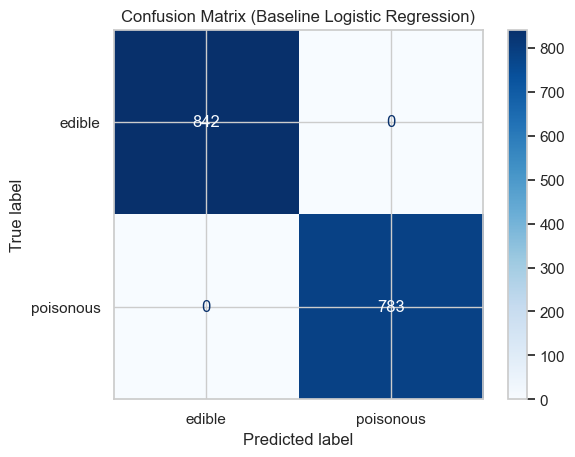

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)

# Baseline Logistic Regression on original standardized features
baseline_clf = LogisticRegression()
baseline_clf.fit(X_train, y_train)

y_pred_baseline = baseline_clf.predict(X_test)

print('\nBaseline Logistic Regression performance on standardized features:')
print('Accuracy:', accuracy_score(y_test, y_pred_baseline))
print('\nClassification report:')
print(classification_report(y_test, y_pred_baseline, target_names=['edible','poisonous'], digits=4))

# Confusion matrix (baseline)
cm_base = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base,
                              display_labels=['edible', 'poisonous'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Baseline Logistic Regression)")
plt.show()

PCA-transformed shapes: (6499, 50) (1625, 50)

PCA Logistic Regression performance:
Accuracy: 0.9987692307692307

Classification report:
              precision    recall  f1-score   support

      edible     0.9976    1.0000    0.9988       842
   poisonous     1.0000    0.9974    0.9987       783

    accuracy                         0.9988      1625
   macro avg     0.9988    0.9987    0.9988      1625
weighted avg     0.9988    0.9988    0.9988      1625



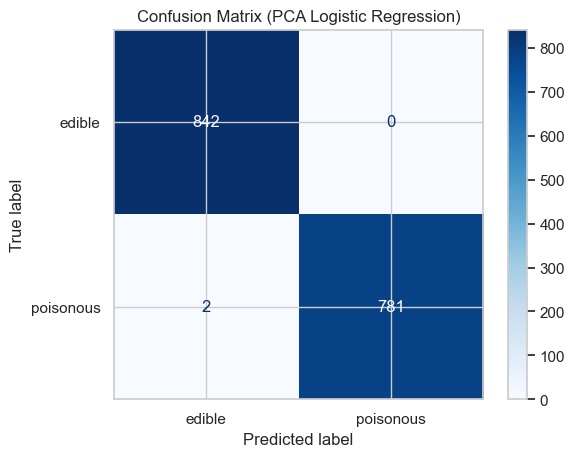

In [40]:
# PCA-transformed Logistic Regression

# Chosen number of components based on earlier cumulative variance (retain 90% of variance)
n_components_90 = 50
pca_model = PCA(n_components=n_components_90)
pca_model.fit(X_train)  

X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

print('PCA-transformed shapes:', X_train_pca.shape, X_test_pca.shape)

pca_clf = LogisticRegression()
pca_clf.fit(X_train_pca, y_train)
y_pred_pca = pca_clf.predict(X_test_pca)

print('\nPCA Logistic Regression performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_pca))
print('\nClassification report:')
print(classification_report(y_test, y_pred_pca, target_names=['edible','poisonous'], digits=4))

cm_pca = confusion_matrix(y_test, y_pred_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca,
                              display_labels=['edible', 'poisonous'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (PCA Logistic Regression)")
plt.show()

### Analysis & Comparison

#### 1. Is there a significant difference in performance?  
In this experiment, the performance of Logistic Regression on the original standardized features and on the PCA-transformed features is very similar, with only a minor drop (0.2 to 0.3% (i.e) only 2 misclassified labels) in accuracy and classification metrics after PCA. This suggests that PCA was able to compress the dataset (reduce dimensionality) while retaining most of the important information. The small difference is due to some information loss from dimensionality reduction, but since 90% of the variance was retained, the impact is minimal.

#### 2. Did PCA's ability to handle feature collinearity and redundancy provide a performance benefit?  
Yes, PCA helps by transforming correlated and redundant features into a set of orthogonal (uncorrelated) principal components. This can improve model stability and interpretability, and may prevent overfitting in some cases. However, in this dataset, the baseline Logistic Regression already performed very well, so the performance benefit from removing collinearity was not dramatic, but PCA still provided a more compact and efficient representation.

#### 3. Usefulness of Logistic Regression as a surrogate for evaluating PCA effectiveness  
Logistic Regression is a good surrogate model for evaluating PCA because it is sensitive to feature redundancy and collinearity. If PCA removes redundant information without hurting performance, it shows that dimensionality reduction was effective. However, Logistic Regression is a linear model; if the dataset or task requires non-linear relationships, other models might be more appropriate for evaluating the true impact of PCA.

---
## Conclusion: Unveiling the Mushroom Mystery

In this data adventure, we journeyed from a high-dimensional, categorical mushroom dataset to a compact, interpretable feature space using Principal Component Analysis (PCA). By carefully applying one-hot encoding and standardization, we prepared our data for PCA, which then transformed our original, redundant feature space into a set of orthogonal principal components, each representing a unique direction of maximum variance.

Through visualizations like scree plots and pair plots, we saw that much of the dataset’s information could be preserved with far fewer dimensions, even though perfect class separation was not achieved in the principal component space. Our performance comparison showed that Logistic Regression, whether trained on the full standardized features or the reduced PCA space, achieved nearly identical results. This demonstrates that PCA effectively compressed the data with minimal information loss, while also removing collinearity and redundancy.

Conceptually, this journey illustrates how PCA rotates the original vector space to new axes that are uncorrelated and ordered by importance, making downstream modeling more stable and efficient. Logistic Regression, as a linear model, benefited from this transformation by operating in a space free from redundant information, confirming the power of dimensionality reduction.

In summary, PCA allowed us to simplify our mushroom dataset without much sacrificing predictive power.